In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial
from matrix_calculator import A_matrix

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
N = 300
r_in = 0.01 # AU
r_out = 1e4 # AU 
r = np.logspace(np.log(r_in), np.log(r_out), N, base = np.exp(1))
r_au = r * u.au
r_log = np.log(r)
Δr_log = r_log[1] - r_log[0]
Ω = (np.sqrt((G * M_sun) / r_au**3)).decompose()

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

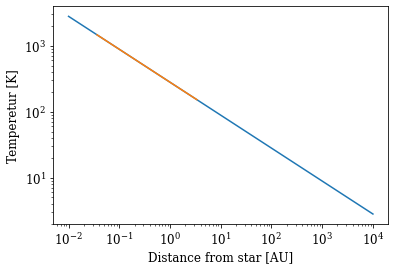

In [4]:
T_1au = 280 * u.K
p = -1/2

T_req = T_1au * (r)**p
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

Text(0.5, 0, 'Distance from star [AU]')

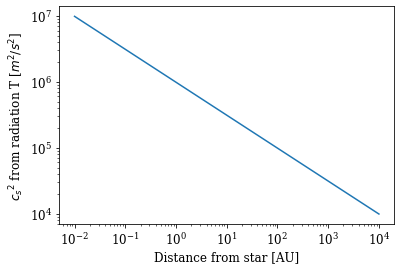

In [5]:
def c_s2(T):
    μ = 2.34
    return ((k_B * T) / (μ * m_p)).decompose()

plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane for MRI-active PPDs
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{3\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the weak DW case (p. 4 Suzuki)
$$F_{rad} = \epsilon_{rad}\left[\frac{3}{2}\Omega\Sigmaα_{rφ}c_s^2 + r\Omegaα_{\phi z}(\rho c_s^2)_{mid}\right],\quad\epsilon_{rad}=0.9$$
$$\Sigma \Omega=\sqrt{2 \pi}(\rho c_s)_{mid}\quad \Rightarrow \quad (\rho c_s)_{mid}=\frac{1}{\sqrt{2 \pi}}\Sigma \Omega
\quad ?\;\Rightarrow\quad (\rho c_s^2)_{mid} = \frac{c_s}{\sqrt{2 \pi}}\Sigma \Omega$$
$$\frac{g}{cm^2}\frac{1}{s} = \frac{kg}{m^3}\frac{m}{s}$$ 



In [6]:
def Frad_weakDW(Σ, cs2, α_rφ = 8e-3, α_φz = 0, ε_rad = 0.9):
    return ε_rad * (3/2 * Ω * Σ * α_rφ * cs2 + r_au * Ω * α_φz * np.sqrt(cs2) / np.sqrt(2*np.pi) * Σ * Ω).decompose()

In [7]:
Frad_weakDW(Σ_initial(r_au), c_s2(T_req))

<Quantity [3.60930250e+009, 3.07031068e+009, 2.61180675e+009,
           2.22177163e+009, 1.88998101e+009, 1.60773731e+009,
           1.36764175e+009, 1.16340039e+009, 9.89659119e+008,
           8.41863363e+008, 7.16138661e+008, 6.09189122e+008,
           5.18211021e+008, 4.40819312e+008, 3.74985104e+008,
           3.18982480e+008, 2.71343252e+008, 2.30818478e+008,
           1.96345722e+008, 1.67021201e+008, 1.42076097e+008,
           1.20856401e+008, 1.02805767e+008, 8.74509324e+007,
           7.43893076e+007, 6.32784237e+007, 5.38269542e+007,
           4.57870784e+007, 3.89479840e+007, 3.31303410e+007,
           2.81816001e+007, 2.39719936e+007, 2.03911334e+007,
           1.73451165e+007, 1.47540637e+007, 1.25500253e+007,
           1.06751993e+007, 9.08041613e+006, 7.72384948e+006,
           6.56991972e+006, 5.58836096e+006, 4.75342750e+006,
           4.04321880e+006, 3.43910520e+006, 2.92523946e+006,
           2.48814121e+006, 2.11634348e+006, 1.80009197e+006,
        

In [8]:
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        T = (T.value).copy()
    else:
        T = T.copy()
    T[T < 150] = 4.5 * (T[T < 150] / 150)**2 

    T[np.where((T >= 150) & (T <= 1500))] = 4.5 

    T[T > 1500] = 0 

    return T * (Σ.to('g/cm2')).value / 2


def tau_P(τ_R):
    τ_R_new = τ_R.copy()
    τ_R_new[2.4 * τ_R_new <= 0.5] = 0.5
    τ_R_new[2.4 * τ_R_new >= 0.5] = 2.4 * τ_R_new
    return τ_R_new

In [9]:
def T_vis_weakDW(T, Σ):
    return ((0.5 * sigma_sb**(-1) * (3/8 * tau_R(T, Σ) + 0.5 * tau_P(tau_R(T, Σ))**(-1)) * Frad_weakDW(Σ, c_s2(T)))**(0.25)).decompose()

In [10]:
T_vis_weakDW(T_req, Σ_initial(r_au))

<Quantity [1.07310589e+04, 1.03058149e+04, 9.89742037e+03, 9.50520769e+03,
           9.12853566e+03, 8.76678850e+03, 8.41937482e+03, 8.08572670e+03,
           7.76529867e+03, 7.45756692e+03, 7.16202836e+03, 6.87819987e+03,
           6.60561743e+03, 6.34383545e+03, 6.09242597e+03, 5.85097798e+03,
           5.61909679e+03, 5.39640331e+03, 5.18253349e+03, 4.97713771e+03,
           4.77988019e+03, 4.59043847e+03, 4.40850285e+03, 4.23377591e+03,
           4.06597202e+03, 3.90481686e+03, 3.75004698e+03, 3.60140937e+03,
           1.63039253e+05, 1.53884928e+05, 1.45244401e+05, 1.37088839e+05,
           1.29391024e+05, 1.22125266e+05, 1.15267317e+05, 1.08794290e+05,
           1.02684583e+05, 9.69178042e+04, 9.14747088e+04, 8.63371307e+04,
           8.14879232e+04, 7.69109023e+04, 7.25907922e+04, 6.85131743e+04,
           6.46644392e+04, 6.10317413e+04, 5.76029560e+04, 5.43666390e+04,
           5.13119883e+04, 4.84288083e+04, 4.57074754e+04, 4.31389060e+04,
           4.07145267e+04

In [11]:
T_req

<Quantity [2800.        , 2736.05350835, 2673.56742878, 2612.50840833,
           2552.8438558 , 2494.54192426, 2437.57149415, 2381.90215658,
           2327.50419717, 2274.34858013, 2222.40693282, 2171.65153055,
           2122.05528182, 2073.59171383, 2026.2349584 , 1979.9597381 ,
           1934.7413528 , 1890.55566646, 1847.37909427, 1805.18859005,
           1763.96163395, 1723.67622042, 1684.31084648, 1645.84450024,
           1608.25664967, 1571.52723167, 1535.63664131, 1500.56572144,
           1466.29575238, 1432.80844199, 1400.0859159 , 1368.11070792,
           1336.8657508 , 1306.33436703, 1276.50025999, 1247.34750528,
           1218.86054212, 1191.02416517, 1163.8235163 , 1137.24407675,
           1111.2716593 , 1085.89240077, 1061.09275458, 1036.85948352,
           1013.1796527 ,  990.04062263,  967.43004249,  945.33584351,
            923.74623258,  902.64968588,  882.03494281,  861.89099992,
            842.20710505,  822.97275162,  804.17767298,  785.81183697,
      

Text(0.5, 0, 'r [AU]')

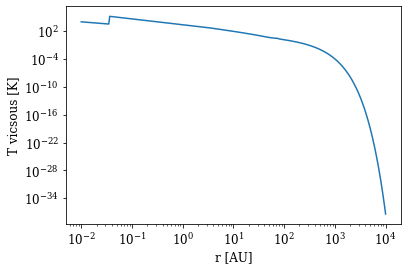

In [17]:
plt.loglog(r, T_vis_weakDW(T_req, Σ_initial(r_au)))
plt.ylabel('T vicsous'+f' [{T_vis_weakDW(T_req, Σ_initial(r_au)).unit}]')
#plt.ylim(1e-3, 1e3)
plt.xlabel(f'r [{r_au.unit}]')

In [13]:
T_vis_weakDW(T_req, Σ_initial(r_au))**4

<Quantity [1.32608178e+016, 1.12805260e+016, 9.59595197e+015,
           8.16293697e+015, 6.94391611e+015, 5.90693397e+015,
           5.02480691e+015, 4.27441053e+015, 3.63607353e+015,
           3.09306207e+015, 2.63114114e+015, 2.23820141e+015,
           1.90394181e+015, 1.61959952e+015, 1.37772025e+015,
           1.17196288e+015, 9.96933182e+014, 8.48042464e+014,
           7.21387261e+014, 6.13647019e+014, 5.21997045e+014,
           4.44034466e+014, 3.77715236e+014, 3.21300551e+014,
           2.73311271e+014, 2.32489144e+014, 1.97763815e+014,
           1.68224776e+014, 7.06591993e+020, 5.60769439e+020,
           4.45038518e+020, 3.53189995e+020, 2.80295802e+020,
           2.22444711e+020, 1.76532525e+020, 1.40095572e+020,
           1.11178540e+020, 8.82295905e+019, 7.00171039e+019,
           5.55636088e+019, 4.40933401e+019, 3.49906191e+019,
           2.77668200e+019, 2.20341528e+019, 1.74848561e+019,
           1.38746822e+019, 1.10097912e+019, 8.73634831e+018,
        

In [14]:
res3 = fsolve(lambda T: (T_vis_weakDW(T, Σ_initial(r_au)).value**4 + T_req.value**4 - T**4), x0 = T_req.value)

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions